In [1]:
import json
import pandas as pd
import tqdm
import texplot
import numpy as np

# Download Input File if it Does Not Exists

Note that the inpout file ``clean_battle_20240814_public.json`` has 2GB in size. The following function downloads it if it does not exists. Also, at the end of this notebook script, delete this file to not take much space for the repository.

In [2]:
# Download input file if it does not exists

import os
import requests
from tqdm import tqdm

def ensure_file_exists(filename, url):
    """
    Check if the file exists locally; if not, download it.
    """

    if not os.path.exists(filename):
        print(f"{filename} not found locally. Downloading from {url}...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                total_size = int(r.headers.get('content-length', 0))
                with tqdm(total=total_size, unit='B', unit_scale=True, desc=f"Downloading {filename}") as progress:
                    for chunk in r.iter_content(chunk_size=8192): 
                        f.write(chunk)
                        progress.update(len(chunk))
        print(f"{filename} has been downloaded.")
    else:
        print(f"{filename} already exists locally.")

def delete_file(filename):
    """Deletes a file if it exists."""
    if os.path.exists(filename):
        os.remove(filename)
        print(f"{filename} has been deleted.")
    else:
        print(f"{filename} does not exist.")

input_file = 'clean_battle_20240814_public.json'
download_url = 'https://storage.googleapis.com/arena_external_data/public/clean_battle_20240814_public.json'

ensure_file_exists(input_file, download_url)

clean_battle_20240814_public.json already exists locally.


# Load Input File (Start Here if File Already Downloaded)

In [3]:
# input_file = 'https://storage.googleapis.com/arena_external_data/public/clean_battle_20240814_public.json'
input_file = 'clean_battle_20240814_public.json'

with open(input_file, 'r') as file:
    battles = pd.read_json(file).sort_values(ascending=True, by=["tstamp"])

print("Before dedup: ", len(battles))
battles = battles[
        battles["dedup_tag"].apply(lambda x: x.get("sampled", False))]
print("After dedup: ", len(battles))

battles = battles[battles["anony"]]
battles

Before dedup:  1799991
After dedup:  1670250


,model_a,model_b,winner,judge,turn,anony,language,tstamp,conv_metadata,is_code,is_refusal,dedup_tag,category_tag
0,chatglm-6b,koala-13b,model_b,2e9c29aa140b8e50643235eab01dc9ea,1,True,English,1.682352e+09,"{'sum_user_tokens': 10, 'sum_assistant_a_token...",True,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 1}, 'math_v..."
1,oasst-pythia-12b,alpaca-13b,tie,2e9c29aa140b8e50643235eab01dc9ea,1,True,English,1.682352e+09,"{'sum_user_tokens': 11, 'sum_assistant_a_token...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 0}, 'math_v..."
2,koala-13b,oasst-pythia-12b,model_b,2e9c29aa140b8e50643235eab01dc9ea,1,True,English,1.682352e+09,"{'sum_user_tokens': 10, 'sum_assistant_a_token...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 0}, 'math_v..."
3,vicuna-13b,oasst-pythia-12b,model_b,2e9c29aa140b8e50643235eab01dc9ea,1,True,English,1.682352e+09,"{'sum_user_tokens': 9, 'sum_assistant_a_tokens...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 1}, 'math_v..."
4,vicuna-13b,koala-13b,model_a,2e9c29aa140b8e50643235eab01dc9ea,1,True,English,1.682352e+09,"{'sum_user_tokens': 5, 'sum_assistant_a_tokens...",False,True,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 0}, 'math_v..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799986,llama-3-8b-instruct,chatgpt-4o-latest,model_a,1f08bb8a2f8f77ef1dd3e2f91c4214f2,1,True,English,1.723665e+09,"{'sum_user_tokens': 18, 'sum_assistant_a_token...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 1}, 'math_v..."
1799987,gpt-4o-2024-08-06,claude-3-5-sonnet-20240620,model_a,211cc2f9ea2b5846cfa3c373f32db8f4,1,True,Russian,1.723665e+09,"{'sum_user_tokens': 436, 'sum_assistant_a_toke...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 3}, 'math_v..."
1799988,llama-3.1-8b-instruct,reka-flash-20240722,tie (bothbad),1bf5cd833334692589920215e6a5ad84,1,True,Polish,1.723665e+09,"{'sum_user_tokens': 28, 'sum_assistant_a_token...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 2}, 'math_v..."
1799989,gemini-1.5-pro-api-0514,claude-3-haiku-20240307,model_a,41893b64a23df36ec2e2acbc7aa78def,2,True,English,1.723665e+09,"{'sum_user_tokens': 42, 'sum_assistant_a_token...",False,False,"{'high_freq': False, 'sampled': True}","{'if_v0.1': {'if': False, 'score': 1}, 'math_v..."


Plot saved to "/home/sia/work/github/leaderbot/notebooks/experimental/match_freq_per_lang.svg".
Plot saved to "/home/sia/work/github/leaderbot/notebooks/experimental/match_freq_per_lang.pdf".


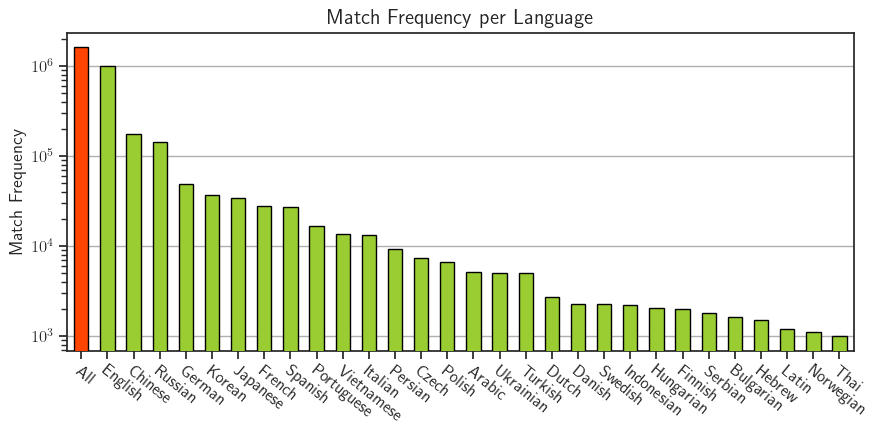

In [11]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import numpy as np

# -----------------------------------

# Color settings
bg_color = 'none'
fg_color = 'black'

grid_color = '#b0b0b0'  # Default grid color, good on white background
# grid_color = (0.3, 0.3, 0.3)

# -----------------------------------

# Count the number of battles for each language
language_counts = battles["language"].value_counts()

# Remove the "unknown" language
language_counts = language_counts.drop("unknown", axis=0)

# Compute total match frequency for all languages
total_matches = language_counts.sum()

# Sort the data for better visualization
sorted_counts = language_counts.sort_values(ascending=False)

top_languages = sorted_counts.head(30)

# Include "All" at the beginning
top_languages_with_all = pd.concat([pd.Series({"All": total_matches}), top_languages])

with texplot.theme(use_latex=True, rc={'font.family': 'sans-serif'}, font_scale=1):
    
    # Create bar positions
    x_positions = np.arange(len(top_languages_with_all))
    
    # Create colors: first bar is "All", the rest are standard
    colors = ['orangered'] + ['yellowgreen'] * (len(top_languages_with_all) - 1)
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(9, 4.5))

    width = 0.55
    for i, (label, value) in enumerate(top_languages_with_all.items()):
        ax.bar(
            x=x_positions[i],
            height=value,
            color=colors[i],
            edgecolor=fg_color,
            zorder=3,
            width=width,
        )
    
    # Set x-axis labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(top_languages_with_all.index)

    # Rotate x-axis labels for better visibility
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
        label.set_transform(label.get_transform() + Affine2D().translate(-8, 0))
    ax.tick_params(axis='x', rotation=-39, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim(-width, len(top_languages) - (1-width)) 
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add title and labels
    ax.set_title("Match Frequency per Language", fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("Match Frequency", fontsize=13)
    
    # Add grid lines
    ax.grid(axis='y', zorder=0, color=grid_color)

    # Foreground color
    if fg_color != 'black':

        # Change axis spine colors
        ax.spines['bottom'].set_color(fg_color)
        ax.spines['top'].set_color(fg_color)
        ax.spines['left'].set_color(fg_color)
        ax.spines['right'].set_color(fg_color)

        # Change tick color
        ax.tick_params(axis='both', which='both', colors=fg_color)

        # Change label color
        ax.xaxis.label.set_color(fg_color)
        ax.yaxis.label.set_color(fg_color)

        # Change title color
        ax.title.set_color(fg_color)

    # Background color
    if bg_color == 'none':
        transparent_bg = True
    else:
        fig.set_facecolor(bg_color)
        ax.set_facecolor(bg_color)
        transparent_bg = False
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    texplot.show_or_save_plot(plt, default_filename='match_freq_per_lang',
                              transparent_background=transparent_bg, dpi=200,
                              show_and_save=True, verbose=True)

In [7]:
# Define categories: win+loss, tie, both bad
def categorize_outcomes(row):
    if (row["winner"] == "tie") or (row["winner"] == "tie (bothbad)"):
        return "Tie"
    else:
        return "Win/Loss"

# Categorize outcomes in a new column using .loc to avoid SettingWithCopyWarning
battles.loc[:, "outcome_category"] = battles.apply(categorize_outcomes, axis=1)

# Group data by language and outcome category
outcome_counts = battles.groupby(["language", "outcome_category"]).size().unstack(fill_value=0)

# Remove the "unknown" language
outcome_counts = outcome_counts.drop("unknown", axis=0)

# Calculate win+loss as a combined category
outcome_counts["Win/Loss"] = outcome_counts.get("Win/Loss", 0)
outcome_counts["Tie"] = outcome_counts.get("Tie", 0)

# Compute the total number of matches for each language
total_matches = outcome_counts.sum(axis=1)

# Sort outcome_counts by total number of matches
outcome_counts = outcome_counts.loc[total_matches.sort_values(ascending=False).index]

all_totals = outcome_counts.sum(axis=0)
outcome_counts.loc["All"] = all_totals

# Normalize the counts by row-wise sum
normalized_counts = outcome_counts.div(total_matches, axis=0)

Plot saved to "/home/sia/work/github/leaderbot/notebooks/experimental/match_freq_per_lang_tie.svg".
Plot saved to "/home/sia/work/github/leaderbot/notebooks/experimental/match_freq_per_lang_tie.pdf".


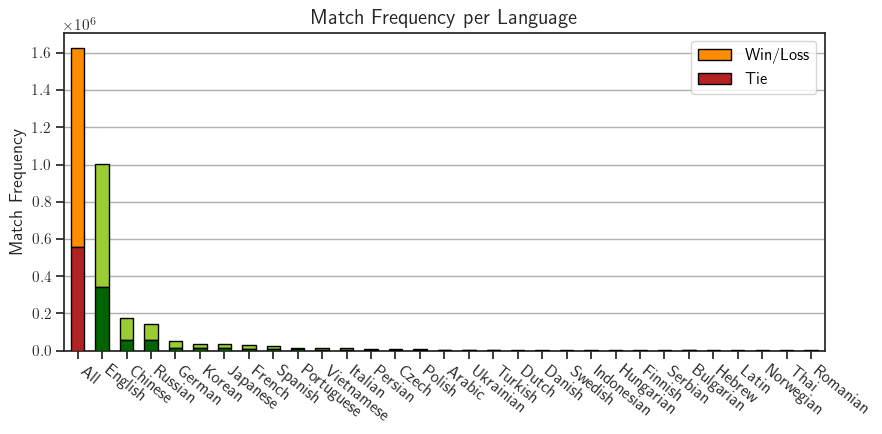

In [21]:
import matplotlib.pyplot as plt

# -----------------------------------

# Color settings
bg_color = 'none'
fg_color = 'black'

grid_color = '#b0b0b0'  # Default grid color, good on white background
# grid_color = (0.3, 0.3, 0.3)

# -----------------------------------

top_languages = outcome_counts.head(30).reset_index()
all_row = pd.DataFrame({"language": ["All"], "Tie": [all_totals["Tie"]], "Win/Loss": [all_totals["Win/Loss"]]})
top_languages = pd.concat([all_row, top_languages], ignore_index=True)

with texplot.theme(use_latex=True, rc={'font.family': 'sans-serif'}, font_scale=1):

    all_bar_colors = ["darkorange", "firebrick"]  # "All" bar colors
    other_bar_colors = ['yellowgreen', 'darkgreen']  # Other bar colors
    
    # Define x positions
    x_positions = np.arange(len(top_languages))
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(9, 4.5))
    
    # Plot each bar
    for i, (_, row) in enumerate(top_languages.iterrows()):
        if row["language"] == "All":
            colors = all_bar_colors
        else:
            colors = other_bar_colors

        width = 0.55
    
        # Plot "Win/Loss" segment
        ax.bar(
            x=x_positions[i],
            height=row["Win/Loss"],
            color=colors[0],
            edgecolor=fg_color,
            zorder=3,
            bottom=row["Tie"],  # Stacked on top of "Tie"
            width=width,
        )
    
        # Plot "Tie" segment
        ax.bar(
            x=x_positions[i],
            height=row["Tie"],
            color=colors[1],
            edgecolor=fg_color,
            zorder=3,
            width=width,
        )
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(top_languages["language"], rotation=-39, ha="left", fontsize=12)
    ax.set_xlim(-width, len(top_languages) - (1-width)) 
    
    # Add title and labels
    ax.set_title("Match Frequency per Language", fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("Match Frequency", fontsize=13)
    
    # Add grid and legend
    ax.grid(axis='y', zorder=0, color=grid_color)

    if bg_color == 'none':
        legend_bg_color = 'white'
    else:
        legend_bg_color = bg_color
    ax.legend(["Win/Loss", "Tie"], title="", fontsize=12, facecolor=legend_bg_color, labelcolor=fg_color)

    # Foreground color
    if fg_color != 'black':

        # Change axis spine colors
        ax.spines['bottom'].set_color(fg_color)
        ax.spines['top'].set_color(fg_color)
        ax.spines['left'].set_color(fg_color)
        ax.spines['right'].set_color(fg_color)

        # Change tick color
        ax.tick_params(axis='both', which='both', colors=fg_color)

        # Change label color
        ax.xaxis.label.set_color(fg_color)
        ax.yaxis.label.set_color(fg_color)

        # Change title color
        ax.title.set_color(fg_color)

    # Background color
    if bg_color == 'none':
        transparent_bg = True
    else:
        fig.set_facecolor(bg_color)
        ax.set_facecolor(bg_color)
        transparent_bg = False
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    texplot.show_or_save_plot(plt, default_filename='match_freq_per_lang_tie',
                              transparent_background=transparent_bg, dpi=200,
                              show_and_save=True, verbose=True)

Plot saved to "/home/sia/work/github/leaderbot/notebooks/experimental/match_freq_per_lang_tie_normalized.svg".
Plot saved to "/home/sia/work/github/leaderbot/notebooks/experimental/match_freq_per_lang_tie_normalized.pdf".


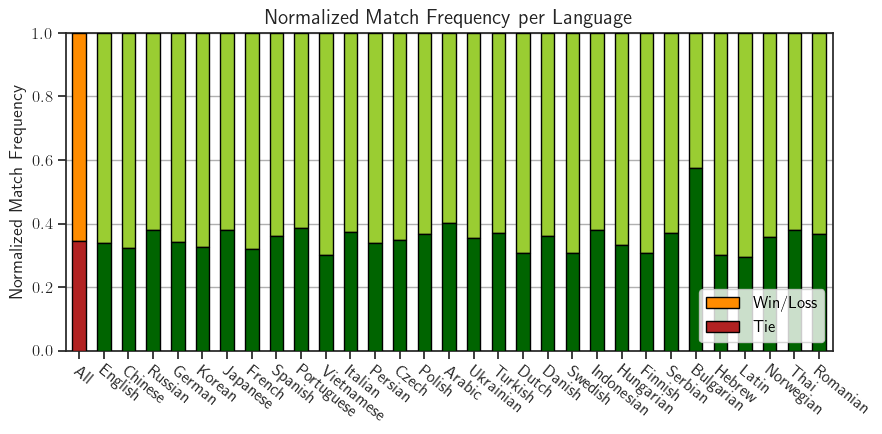

In [20]:
# -----------------------------------

# Color settings
bg_color = 'none'
fg_color = 'black'

grid_color = '#b0b0b0'  # Default grid color, good on white background
# grid_color = (0.3, 0.3, 0.3)

# -----------------------------------

# Normalize the counts by row-wise sum
normalized_counts = top_languages[["Win/Loss", "Tie"]].div(
    top_languages[["Win/Loss", "Tie"]].sum(axis=1), axis=0
)

# Define x positions
x_positions = np.arange(len(top_languages))

with texplot.theme(use_latex=True, rc={'font.family': 'sans-serif'}, font_scale=1):

    # Define colors
    all_bar_colors = ["darkorange", "firebrick"]  # "All" bar colors
    other_bar_colors = ['yellowgreen', 'darkgreen']  # Other bar colors
    
    fig, ax = plt.subplots(figsize=(9, 4.5))
    width = 0.55
    
    # Plot each bar
    for i, (_, row) in enumerate(normalized_counts.iterrows()):
        if top_languages.iloc[i]["language"] == "All":
            colors = all_bar_colors
        else:
            colors = other_bar_colors

        # Plot "Win/Loss" segment
        ax.bar(
            x=x_positions[i],
            height=row["Win/Loss"],
            color=colors[0],
            edgecolor=fg_color,
            zorder=3,
            bottom=row["Tie"],  # Stacked on top of "Tie"
            width=width,
        )

        # Plot "Tie" segment
        ax.bar(
            x=x_positions[i],
            height=row["Tie"],
            color=colors[1],
            edgecolor=fg_color,
            zorder=3,
            width=width,
        )

    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(top_languages["language"])

    # Rotate x-axis labels for better visibility
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
        label.set_transform(label.get_transform() + Affine2D().translate(-8, 0))
    ax.tick_params(axis='x', rotation=-39, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    ax.set_xlim(-width, len(top_languages) - (1-width))

    # Add title and labels
    ax.set_title("Normalized Match Frequency per Language", fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("Normalized Match Frequency", fontsize=13)
    
    # Add grid and legend
    ax.grid(axis='y', zorder=0, color=grid_color)

    if bg_color == 'none':
        legend_bg_color = 'white'
    else:
        legend_bg_color = bg_color
    ax.legend(["Win/Loss", "Tie"], title="", fontsize=12, loc='lower right',
              facecolor=legend_bg_color, labelcolor=fg_color)

    ax.set_ylim([0, 1])  # Ensure normalized values

    # Foreground color
    if fg_color != 'black':

        # Change axis spine colors
        ax.spines['bottom'].set_color(fg_color)
        ax.spines['top'].set_color(fg_color)
        ax.spines['left'].set_color(fg_color)
        ax.spines['right'].set_color(fg_color)

        # Change tick color
        ax.tick_params(axis='both', which='both', colors=fg_color)

        # Change label color
        ax.xaxis.label.set_color(fg_color)
        ax.yaxis.label.set_color(fg_color)

        # Change title color
        ax.title.set_color(fg_color)

    # Background color
    if bg_color == 'none':
        transparent_bg = True
    else:
        fig.set_facecolor(bg_color)
        ax.set_facecolor(bg_color)
        transparent_bg = False
        
    plt.tight_layout()
    texplot.show_or_save_plot(plt, default_filename='match_freq_per_lang_tie_normalized',
                              transparent_background=transparent_bg, dpi=200,
                              show_and_save=True, verbose=True)

# Delete Input file (2GB in size)

In [5]:
# Delete input file as it takes 2GB in size
delete_file(input_file)

clean_battle_20240814_public.json has been deleted.
